# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
!python -m pip install torchmetrics wandb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

import wandb

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

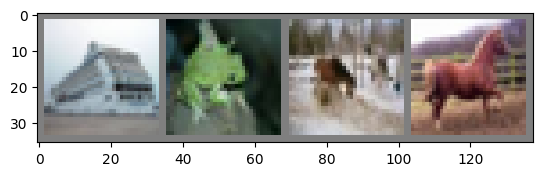

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

Для реализации взял пример из официальной документации pytorch по ResNet:

https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

In [6]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self, downsample= None):
        super(BasicBlockNet, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size= 3, stride= 1, padding= 1),
                        nn.BatchNorm2d(32),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding= 1),
                        nn.BatchNorm2d(32))
        self.relu = nn.ReLU()
        self.conv1x1 = nn.Conv2d(3, 32, kernel_size = 1)
        self.avgpool = nn.AvgPool2d(16, stride= 5)
        self.fc = nn.Linear(32*4*4, n_classes)
        self.downsample = downsample


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        # print('Первый слой:', out.shape)
        out = self.conv2(out)
        # print('Второй слой:', out.shape)
        if self.downsample:
            residual = self.downsample(x)
        # print('Размерность residual:', residual.shape)
        out += self.conv1x1(residual)
        # print('Размерность residual после слоя:', out.shape)
        out = self.relu(out)
        out = self.avgpool(out)
        # print('Размерность после avgpool:', out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=16, stride=5, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [11]:
def test(model, loader, criterion, metric):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        # <your code here>
        data, target = data.to(device), target.to(device)
        predict = model(data)
        loss = criterion(predict, target)
        loss_log.append(loss.item())

        # <your code here>
        acc = metric(predict, target)
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, criterion, metric, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        # <your code here>
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predict = model(data)
        loss = criterion(predict, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

        # <your code here>
        acc = metric(predict, target)
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, criterion, metric, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, metric, train_loader)
        val_loss, val_acc = test(model, val_loader, criterion, metric)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [12]:
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task= 'multiclass', num_classes= n_classes).to(device)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.5481139473766905, train acc: 0.4400585988975748
 val loss: 1.368846461113463, val acc: 0.5086657801841168

Epoch 1
 train loss: 1.2535581305432364, train acc: 0.5585009140767825
 val loss: 1.162066624266036, val acc: 0.6005540780564572

Epoch 2
 train loss: 1.129761828800878, train acc: 0.604123139185269
 val loss: 1.1139697161126645, val acc: 0.6077570921563088

Epoch 3
 train loss: 1.051564722762901, train acc: 0.6316148146196955
 val loss: 1.062600610104013, val acc: 0.6227171986661059

Epoch 4
 train loss: 1.0085226563256664, train acc: 0.6502228062157221
 val loss: 1.0177819498041842, val acc: 0.6418439716734785

Epoch 5
 train loss: 0.9831686735806997, train acc: 0.6558541720920332
 val loss: 1.0087400043264347, val acc: 0.6516179077168729

Epoch 6
 train loss: 0.9467997707876035, train acc: 0.6719321297989032
 val loss: 0.9970016431301199, val acc: 0.6607934396317665

Epoch 7
 train loss: 0.9253898708650355, train acc: 0.677963404267536
 val loss: 0.947017

Посчитайте точность на тестовой выборке:

In [13]:
# <your code here>
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Test score: 0.7125796178343949


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

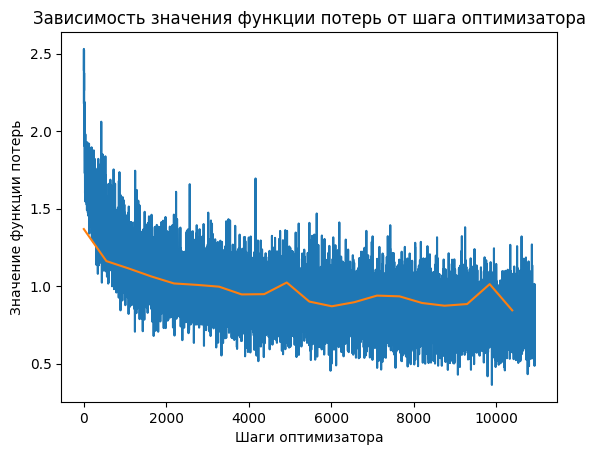

In [14]:
# <your code here>
plt.title('Зависимость значения функции потерь от шага оптимизатора')
plt.plot(train_loss_log)

val_step = [len(train_loader) * step for step in range(len(val_loss_log))]
plt.plot(val_step, val_loss_log)

plt.xlabel('Шаги оптимизатора')
plt.ylabel('Значение функции потерь')
plt.show()

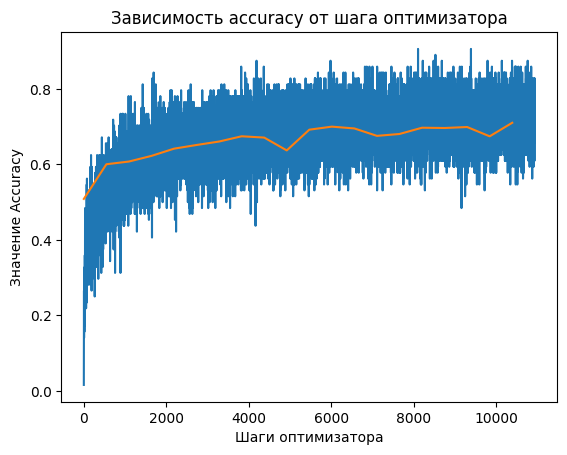

In [15]:
plt.title('Зависимость accuracy от шага оптимизатора')
plt.plot(train_acc_log)
plt.plot(val_step, val_acc_log)

plt.xlabel('Шаги оптимизатора')
plt.ylabel('Значение Accuracy')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [16]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5813952549284076, train acc: 0.4258985701383141
 val loss: 1.4441655651051948, val acc: 0.48867464534779814

Epoch 1
 train loss: 1.2786382617636616, train acc: 0.5456344672705181
 val loss: 1.2689804675731253, val acc: 0.5508865248649678

Epoch 2
 train loss: 1.145334879375681, train acc: 0.5997527095691814
 val loss: 1.128715900410997, val acc: 0.5968085106382979

Epoch 3
 train loss: 1.0723092528758145, train acc: 0.6241267301700669
 val loss: 1.0443112479879502, val acc: 0.6318484042553192

Epoch 4
 train loss: 1.0229674627837577, train acc: 0.6442649842834124
 val loss: 1.01452841682637, val acc: 0.6466976949509154

Epoch 5
 train loss: 0.9873073819132566, train acc: 0.6583474797130285
 val loss: 0.9497560359062033, val acc: 0.6720744680851064

Epoch 6
 train loss: 0.9658841259736684, train acc: 0.6627464742285678
 val loss: 0.9857973296591576, val acc: 0.6593085106382979

Epoch 7
 train loss: 0.936519184212798, train acc: 0.6752170932358318
 val loss: 0.927

Посчитайте точность на тестовой выборке:

In [17]:
# <your code here>
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Test score: 0.7220342356687898


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.001, momentum= 0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Epoch 0
 train loss: 1.9067759195672964, train acc: 0.31700509271739385
 val loss: 1.7018423247844614, val acc: 0.40503102832652155

Epoch 1
 train loss: 1.625539428355271, train acc: 0.4205038848263254
 val loss: 1.549035106821263, val acc: 0.4490913120990104

Epoch 2
 train loss: 1.5131352490437313, train acc: 0.45905833766272996
 val loss: 1.4552622632777437, val acc: 0.47522163124794653

Epoch 3
 train loss: 1.4449765392369718, train acc: 0.4861419430816413
 val loss: 1.4016122914375142, val acc: 0.49971187939035133

Epoch 4
 train loss: 1.3909381301137167, train acc: 0.5079777683156935
 val loss: 1.3406424248472173, val acc: 0.5226285461415636

Epoch 5
 train loss: 1.3313649289132907, train acc: 0.529707495429616
 val loss: 1.3002079649174467, val acc: 0.5421985815180109

Epoch 6
 train loss: 1.290339968540115, train acc: 0.5444592256541662
 val loss: 1.2509841084480287, val acc: 0.5585328014607125

Epoch 7
 train loss: 1.255429241404455, train acc: 0.5556281012852405
 val loss: 1

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [19]:
### LinearLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor= 1.0, end_factor= 0.01, total_iters= 20)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')


Epoch 0
 train loss: 1.5655715670402568, train acc: 0.43367638415784676
 val loss: 1.37539099987517, val acc: 0.5140292553191489

Epoch 1
 train loss: 1.243136505322221, train acc: 0.5610676743430673
 val loss: 1.1152033559819485, val acc: 0.6083554965384463

Epoch 2
 train loss: 1.1137568010272665, train acc: 0.6077386393625513
 val loss: 1.082639479637146, val acc: 0.6206338651636814

Epoch 3
 train loss: 1.034608478411024, train acc: 0.638241871292456
 val loss: 1.1388988413709276, val acc: 0.6054964539852549

Epoch 4
 train loss: 0.9840082764843482, train acc: 0.6567274419219664
 val loss: 0.9908037226250831, val acc: 0.6535682624958931

Epoch 5
 train loss: 0.9520249279042267, train acc: 0.6674392792162991
 val loss: 1.0474714745866491, val acc: 0.6429078014607125

Epoch 6
 train loss: 0.9238480660771539, train acc: 0.6786408004856632
 val loss: 0.934787606178446, val acc: 0.6752437944107867

Epoch 7
 train loss: 0.8957821351409613, train acc: 0.6910706124314442
 val loss: 0.89176

In [20]:
### StepLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)

print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Epoch 0
 train loss: 1.575267213354163, train acc: 0.42974258940224236
 val loss: 1.388573621689005, val acc: 0.5023936170212766

Epoch 1
 train loss: 1.290832673173936, train acc: 0.5411987463778508
 val loss: 1.209838482674132, val acc: 0.5755762412192974

Epoch 2
 train loss: 1.1581901304246738, train acc: 0.5930073126142597
 val loss: 1.112239353961133, val acc: 0.6057624114320633

Epoch 3
 train loss: 1.0804511653004008, train acc: 0.6193727148080439
 val loss: 1.1024592455397262, val acc: 0.6184175531914894

Epoch 4
 train loss: 1.0399803937680108, train acc: 0.6380378362029736
 val loss: 1.0022015642612538, val acc: 0.6498670212765958

Epoch 5
 train loss: 0.9000658433223773, train acc: 0.687761164779419
 val loss: 0.9048758527065845, val acc: 0.6910904255319149

Epoch 6
 train loss: 0.8731121001339481, train acc: 0.6987668124369772
 val loss: 0.8982747998643429, val acc: 0.6932402481424048

Epoch 7
 train loss: 0.8628140746784384, train acc: 0.7014151867172618
 val loss: 0.8855

Your answers here: к имющимся данным попробовал применить StepLR и LinearLR. Первый планировщик снижает learning_rate умножая его на gamma через каждое количество шагов, которое передано в параметр step_size. С его помощью не получилось добиться значимого эффекта. Применяя второй планировщик я с первой эпохи начинаю постепенное снижение learning_rate умножая его на значения от единицы до 0.01. Таким образом на 20-ой эпохе обучения learning_rate равен 0.001. Применение такого планировщика дало небольшой прирост метрики Accuracy на тестовых данных. Объяснить почему произошло улучшение Accuracy именно при применении LinearLR нет возможности, так как оно обусловлено рельефом поверхности функции потерь, увидеть которую мы не в состоянии, но снижениие величины шага, которое задано данным шедулером, позволило найти точку минимума функции потерь более низкую, чем без его применения. Поэтому выбор данного шедулера был произведен методом множественных проб и измерением качества предикта модели на тестовых данных. Не исключаю, что есть более подходящий шедулер, который позволит добиться более высокого результата.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

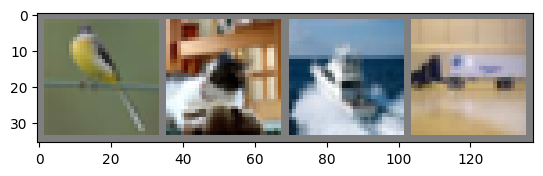

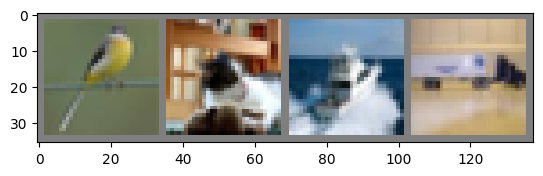

In [21]:
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [22]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.565912195707806, train acc: 0.433790643755653
 val loss: 1.373813960907307, val acc: 0.5117242908224147

Epoch 1
 train loss: 1.2365771981000464, train acc: 0.5580438756855576
 val loss: 1.1309396895956485, val acc: 0.6005540780564572

Epoch 2
 train loss: 1.120636375665229, train acc: 0.6075917341809386
 val loss: 1.0955860713694958, val acc: 0.6179742906955963

Epoch 3
 train loss: 1.063871739115532, train acc: 0.6281584617860574
 val loss: 1.0611435129287394, val acc: 0.6380984042553192

Epoch 4
 train loss: 1.0186787357713885, train acc: 0.6427632867745116
 val loss: 1.1092242532588066, val acc: 0.6109707446808511

Epoch 5
 train loss: 0.9918017790565979, train acc: 0.6560949334496772
 val loss: 0.9766917304789766, val acc: 0.6593971630360218

Epoch 6
 train loss: 0.9730148074613847, train acc: 0.6594819143223806
 val loss: 1.0216633606464305, val acc: 0.6371232269926274

Epoch 7
 tra

Посчитайте точность на тестовой выборке:

In [23]:
# <your code here>
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Test score: 0.7200437898089171


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [24]:
# <your code here>
transform = transforms.Compose(
        [transforms.RandomRotation(degrees= (0, 180)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones= [10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.839684486607093, train acc: 0.3323770893339265
 val loss: 1.7442096314531692, val acc: 0.35675975173077684

Epoch 1
 train loss: 1.6625615733197228, train acc: 0.40126338470352635
 val loss: 1.647725454797136, val acc: 0.40246010638297874

Epoch 2
 train loss: 1.5821877887959455, train acc: 0.4307056346148852
 val loss: 1.5705470582272143, val acc: 0.43909574468085105

Epoch 3
 train loss: 1.5312659450597257, train acc: 0.4524802493656793
 val loss: 1.4891482748883835, val acc: 0.46615691489361705

Epoch 4
 train loss: 1.4769450003311881, train acc: 0.4676604531364859
 val loss: 1.535037798069893, val acc: 0.456826241092479

Epoch 5
 train loss: 1.445214535462137, train acc: 0.483966929984485
 val loss: 1.4549673060153394, val acc: 0.48189273045418113

Epoch 6
 train loss: 1.4243425390184252, train acc: 0.4905939866572455
 val loss: 1.4386553845507033, val acc: 0.49011524826922315

Epoch 

In [25]:
# <your code here>
transform = transforms.Compose(
        [transforms.ColorJitter(brightness= .5),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones= [10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 30, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6554226177919935, train acc: 0.3995617328439814
 val loss: 1.4176631876762877, val acc: 0.4960328014607125

Epoch 1
 train loss: 1.3541305402951005, train acc: 0.5190242230347349
 val loss: 1.2206883133725916, val acc: 0.5719193263256803

Epoch 2
 train loss: 1.2047451802102043, train acc: 0.5767294006112289
 val loss: 1.1857705278599515, val acc: 0.5892508864402771

Epoch 3
 train loss: 1.12383886828501, train acc: 0.607306085186423
 val loss: 1.1819560748465519, val acc: 0.6029033688788719

Epoch 4
 train loss: 1.0745585015966426, train acc: 0.6259018346749015
 val loss: 1.1081119479017054, val acc: 0.6146054965384463

Epoch 5
 train loss: 1.0344109075378891, train acc: 0.6409024876258055
 val loss: 1.0546706212327834, val acc: 0.6284574468085107

Epoch 6
 train loss: 1.0100705661764964, train acc: 0.6494189083467236
 val loss: 1.051085060961703, val acc: 0.6280585106382979

Epoch 7
 tr

In [26]:
# <your code here>
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=(0, 180)),
         transforms.ColorJitter(brightness=.5, hue=.3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones= [10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)
print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 2.0398929088599504, train acc: 0.25744727733366235
 val loss: 1.9190772087016004, val acc: 0.30454343975858483

Epoch 1
 train loss: 1.8852240256897057, train acc: 0.3198493405822426
 val loss: 1.8290676989453905, val acc: 0.33240248224836716

Epoch 2
 train loss: 1.799428710771871, train acc: 0.3516216701410806
 val loss: 1.786958257695462, val acc: 0.3632092198158832

Epoch 3
 train loss: 1.757843735231124, train acc: 0.3731596043275523
 val loss: 1.7132464616856677, val acc: 0.3935062057160317

Epoch 4
 train loss: 1.716396004887778, train acc: 0.38518134631230144
 val loss: 1.7241999976178433, val acc: 0.3798093971419842

Epoch 5
 train loss: 1.682199951499646, train acc: 0.40293647166361973
 val loss: 1.7393109453485367, val acc: 0.38415336875205347

Epoch 6
 train loss: 1.6502716709098606, train acc: 0.40788227995309356
 val loss: 1.67529937257158, val acc: 0.39297429082241464

Epoch 

Your answers here: Применил случайные цветовые изменения изображений - яркость и оттенки(ColorJitter) и случайные повороты от 0 до 180 градусов (RandomRotation). Такие преобразования применяются для снижения переобучения и делают тренировочный набор данных более разноообразным. В нашем случае, видимо, достаточно применить минимальные трансформации, при этом увеличить число эпох. Если сделать несколько различных преобразований данных, то это приводит к существенному снижению метрик.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [27]:
# <your code here>
wandb.login()

wandb.init(
    project = "my-homework-cnn",

    config = {
        "learning_rate": 0.1,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 20,
        }
    )

def test(model, loader, criterion, metric):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)
        predict = model(data)
        loss = criterion(predict, target)
        loss_log.append(loss.item())

        acc = metric(predict, target)
        acc_log.append(acc.item())

        wandb.log({"Accuracy valid": acc, "Loss valid": loss})

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, criterion, metric, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predict = model(data)

        loss = criterion(predict, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

        acc = metric(predict, target)
        acc_log.append(acc.item())

        wandb.log({"Accuracy train": acc, "Loss train": loss})

    return loss_log, acc_log

def train(model, optimizer, criterion, metric, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, metric, train_loader)
        val_loss, val_acc = test(model, val_loader, criterion, metric)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ivanyuminov747 (my_org_name). Use `wandb login --relogin` to force relogin


In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= 0.1, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task= 'multiclass', num_classes= n_classes).to(device)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor= 1.0, end_factor= 0.01, total_iters= 20)

transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)


tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, metric, 20, train_loader, val_loader, scheduler)

print(f'Test score: {test(net, test_loader, criterion, metric)[1]}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5629249353513421, train acc: 0.43255011102617114
 val loss: 1.3534128437650965, val acc: 0.5168218085106383

Epoch 1
 train loss: 1.262250333207181, train acc: 0.5548976560615316
 val loss: 1.172967967073968, val acc: 0.5912234042553192

Epoch 2
 train loss: 1.1319430522770506, train acc: 0.6039599111572698
 val loss: 1.189879917844813, val acc: 0.5830673759287976

Epoch 3
 train loss: 1.0751317224075414, train acc: 0.6259140767824497
 val loss: 1.1097380749722745, val acc: 0.6139184397585848

Epoch 4
 train loss: 1.0173994022705872, train acc: 0.6478355967148567
 val loss: 1.0131668166911347, val acc: 0.6524157800572984

Epoch 5
 train loss: 0.9802801179711518, train acc: 0.6598695808616373
 val loss: 1.0291483265288333, val acc: 0.6345966312479465

Epoch 6
 train loss: 0.963182059131985, train acc: 0.6666476234003657
 val loss: 0.9429281166259279, val acc: 0.6752437944107867

Epoch 7
 t